In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from scipy import special
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import base, metrics, decomposition, preprocessing, naive_bayes, model_selection

## Graph Mining Project Final Presentation: Anomaly Detection Graphs

This is the final update presentation on anomaly detection in transaction graphs.

## Last Time

In the update presentation, I described the success metric of the precision recall curve, and implemented three algorithms for outlier detection:

- Global Outlier Detection Algorithm (GLODA)
- Direct Neighbor Detection Algorithm (DNODA)
- Community Neighbor algorithm (CNA)

## Since Then

Since then I have extended each algorithm in a few ways:

1. Include all data in the graph, not just subset of the dataset that is being analyzed
1. Implement a simple classifier that takes in the results of the graph algorithms to improve the results of the algorithm more.
1. Implemented the final algorithm: OddBall

In [2]:
def evaluate(gt, pred):
    precision, recall, _ = metrics.precision_recall_curve(gt, pred, pos_label=1)
    precision[-1] = precision[-2]
    precision[0] = precision[1 % len(recall)]
    auc = metrics.auc(recall, precision)
    fig, ax = plt.subplots()
    fig.suptitle("Precision Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.plot(recall, precision)
    return auc, ax

Loading in the data just as before. However, as we are implementing a classifier, we are also splitting the data up into a 80% training and 20% testing set:

In [3]:
data_root = "../data/"

In [4]:
pca = decomposition.PCA(n_components=0.8)
filepath = os.path.join(data_root, "elliptic_bitcoin_dataset/")
edgelist = pd.read_csv(os.path.join(filepath, "elliptic_txs_edgelist.csv"))
features = pd.read_csv(os.path.join(filepath, "elliptic_txs_features.csv"), header = None)
classes = pd.read_csv(os.path.join(filepath, "elliptic_txs_classes.csv"))
reduced_features = pd.DataFrame(pca.fit_transform(features.drop(columns=0).values))
reduced_features["txId"] = features[0]
known_classes = classes[classes['class'] != "unknown"].copy()
known_classes['class'] = 2 - known_classes['class'].astype('int32')
D = pd.merge(known_classes, reduced_features, on="txId", how="inner")
D_ids = set(D['txId'])
edge_ids = set(edgelist['txId1']).union(set(edgelist['txId2']))
ids = D_ids.intersection(edge_ids)
known_edgelist = edgelist[ edgelist['txId1'].isin(ids) & edgelist['txId2'].isin(ids)]
D = D[D['txId'].isin(ids)]
train, test = model_selection.train_test_split(D, test_size=0.2)
train_y = train[["txId", "class"]]
train_X = train.drop(columns=["txId", "class"])
test_y = test[["txId", "class"]]
test_X = test.drop(columns=["txId", "class"])
G = nx.from_pandas_edgelist(edgelist, source="txId1", target="txId2", create_using=nx.MultiGraph)
nx.set_node_attributes(G=G, name="D", values=dict(zip(reduced_features["txId"], reduced_features.drop(columns="txId").values)))

## Improvements to previous models

### GLODA

Instead of using LOF, I use a simple naive bayesian classifier to create predictions without regard to the graph structure. Needless to say the model performs much better than before:

In [5]:
class GLODA(base.BaseEstimator):
    def __init__(self):
        self.classifier_ = naive_bayes.GaussianNB()
    
    def fit(self, X = None, y = None):
        gt = y['class']
        self.classifier_.fit(X, gt)
        return self
    
    def predict_proba(self, X = None, y = None):
        return self.classifier_.predict_proba(X)[:, 1]

GLODA AUC: 6.48e-01


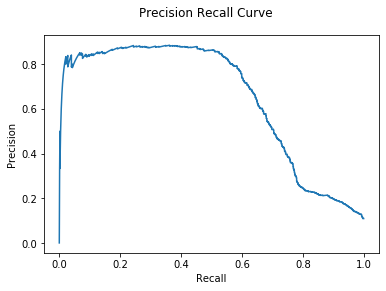

In [6]:
knn = 20
M = GLODA()
M.fit(train_X, train_y)
pred_probs = M.predict_proba(test_X)
auc, ax = evaluate(test_y["class"], pred_probs)
print("GLODA AUC: {:.2e}".format(auc))
plt.show()

### DNODA

In DNODA added to the classifier is data on the direct neighbors in the graph structure.

In [7]:
class DNODA(base.BaseEstimator):
    def __init__(self, G):
        self.G_ = G
        self.classifier_ = naive_bayes.GaussianNB()
        self.generate_distances()
        
    def generate_distances(self):
        self.distances_ = {}
        node_data = nx.get_node_attributes(G=self.G_, name="D")
        for v, d in node_data.items():
            neighbors = np.array([node_data[u] for u in self.G_.neighbors(v)])
            self.distances_[v] = np.sum(d - neighbors, axis=0) / self.G_.degree(v) + 1
    
    def make_data(self, txIds):
        ex = self.distances_[txIds.iloc[0]]
        data = np.zeros((len(txIds), len(ex) * 2))
        node_data = nx.get_node_attributes(G=self.G_, name="D")
        for idx, v in enumerate(txIds):
            data[idx] = np.concatenate([self.distances_[v], node_data[v]])
        return data
    
    def fit(self, X = None, y = None):
        gt = y['class']
        ids = y['txId']
        data = self.make_data(ids)
        self.classifier_.fit(data, gt)
        return self
    
    def predict_proba(self, X = None, y = None):
        data = self.make_data(y)
        return self.classifier_.predict_proba(data)[:, 1]

DNODA AUC: 6.30e-01


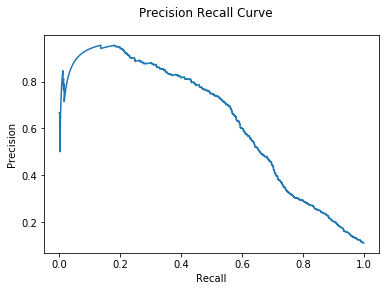

Wall time: 4.29 s


In [8]:
%%time
M = DNODA(G)
M.fit(y=train_y)
pred_probs = M.predict_proba(y=test_y['txId'])
auc, ax = evaluate(test_y["class"], pred_probs)
print("DNODA AUC: {:.2e}".format(auc))
plt.show()

Right now we can get better results with the DNODA algorithm than with GLODA. Let's see if CNA gives even more improvement:

### Community Outlier Detection (CNA)

CNA is extremely similar to DNODA, but instead of comparing each node to just its direct neighbors, the algorithm first runs a community clustering algorithm then performs an average distance calculation to all of the other nodes in its community. If a node has a high distance from the other nodes in its community it is considered more anomalous.

For simplicity's sake, we are simply using a label propagation community clustering algorithm, although any community algorithm would work here.

In [9]:
class CNA(base.BaseEstimator):
    def __init__(self, G):
        self.G_ = G
        self.classifier_ = naive_bayes.GaussianNB()
        self.generate_distances()
        
    def generate_distances(self):
        self.distances_ = {}      
        node_data = nx.get_node_attributes(G=self.G_, name="D")    
        communities = nx.connected_components(self.G_)
        for c in communities:
            comm_data = np.array([node_data[u] for u in c])
            for v in c:
                d = node_data[v]
                self.distances_[v] = np.sum(d - comm_data, axis=0) / self.G_.degree(v) + 1
    
    def make_data(self, txIds):
        ex = self.distances_[txIds.iloc[0]]
        data = np.zeros((len(txIds), len(ex)*2))
        node_data = nx.get_node_attributes(G=self.G_, name="D")
        for idx, v in enumerate(txIds):
            data[idx] = np.concatenate([self.distances_[v], node_data[v]])
        return data
    
    def fit(self, X = None, y = None):
        gt = y['class']
        ids = y['txId']
        data = self.make_data(ids)
        self.classifier_.fit(data, gt)
        return self
    
    def predict_proba(self, X = None, y = None):
        data = self.make_data(y)
        return self.classifier_.predict_proba(data)[:, 1]

CNA AUC: 6.26e-01


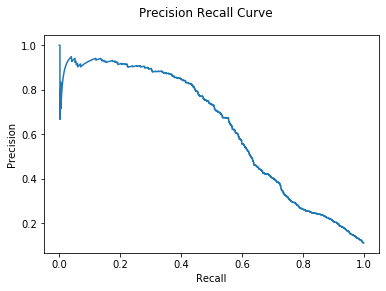

Wall time: 50.2 s


In [10]:
%%time
M = CNA(G)
M.fit(y=train_y)
pred_probs = M.predict_proba(y=test_y['txId'])
auc, ax = evaluate(test_y["class"], pred_probs)
print("CNA AUC: {:.2e}".format(auc))
plt.show()

All three algorithms are significantly improved with the help of a classifier. It is clear that outlier behavior in this dataset is more than just distance from the average.

### Hybrid Model

Similar to the previous update, we make a hybrid to see if we can improve our results just a bit more.

In [11]:
class Hybrid(base.BaseEstimator):
    def __init__(self, models, agg_fun = lambda x: np.mean(x, axis=0)):
        self.models_ = models
        self.agg_fun_ = agg_fun
    
    def fit(self, X, y = None):
        for m in self.models_:
            m.fit(X, y)
        return self
    
    def predict_proba(self, X, y = None):
        result = [m.predict_proba(X, y) for m in self.models_]
        return self.agg_fun_(result)

Hybrid Mean AUC: 6.49e-01


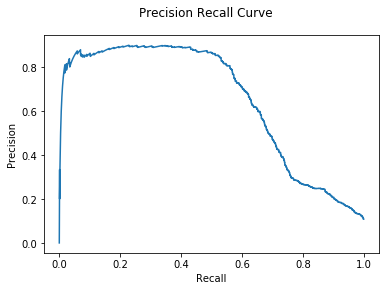

Wall time: 49.3 s


In [12]:
%%time
M = Hybrid(models = [GLODA(), DNODA(G), CNA(G)])
M.fit(X = train_X, y = train_y)
pred_probs = M.predict_proba(X = test_X, y = test_y['txId'])
auc, ax = evaluate(test_y["class"], pred_probs)
print("Hybrid Mean AUC: {:.2e}".format(auc))
plt.show()

Hybrid Min AUC: 6.26e-01


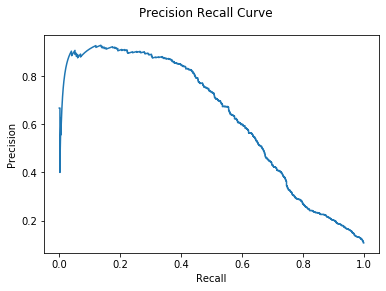

Wall time: 49.3 s


In [13]:
%%time
M = Hybrid(models = [GLODA(), DNODA(G), CNA(G)], agg_fun=lambda x: np.max(x, axis=0))
M.fit(X = train_X, y = train_y)
pred_probs = M.predict_proba(X = test_X, y = test_y['txId'])
auc, ax = evaluate(test_y["class"], pred_probs)
print("Hybrid Min AUC: {:.2e}".format(auc))
plt.show()

Again, using a Hybrid model gives some small improvement.

## OddBall

OddBall works on the observation that real-world graphs typically show a power law relationship between the number of nodes vs edges or total weight between nodes in a 1-step neighborhood of each node, which they refer to as an "egonet". Let's observe if a power law relationship is observed in this dataset:

In [14]:
def egonet(G, ego, k = 1):
    nodes = set()
    fringe = set([ego])
    for step in range(k):
        new_fringe = set()
        for v in fringe:
            new_fringe = new_fringe.union(G.neighbors(v))
        nodes = nodes.union(fringe)
        fringe = new_fringe.difference(nodes)
    nodes = nodes.union(fringe)
    return nodes

In [15]:
egonets = []
for ego in G.nodes():
    egonets.append(egonet(G, ego))

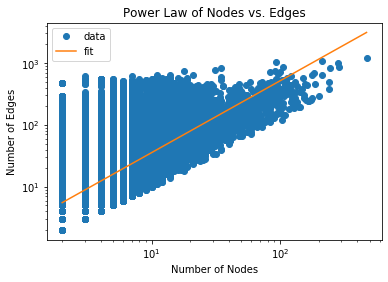

In [16]:
x = []
y = []

for e in egonets:
    x.append(len(e))
    y.append(len(G.edges(nbunch=e)))
    
x_log = np.log(x)
y_log = np.log(y)
m, b = np.polyfit(x_log, y_log, 1)
x_fit = np.unique(x_log)
y_fit = m * x_fit + b
plt.title('Power Law of Nodes vs. Edges')
plt.plot(x, y, 'o', label="data")
plt.plot(np.exp(x_fit), np.exp(y_fit), label="fit")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Edges')
plt.legend(loc='upper left')
plt.show()

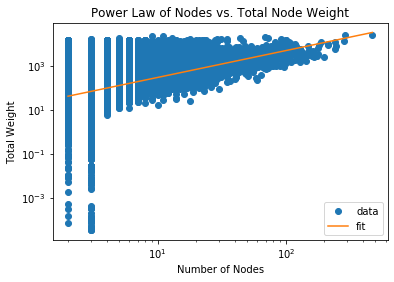

In [17]:
x = []
y = []

node_data = nx.get_node_attributes(G, "D")
for e in egonets:
    distance = 0
    for v, u in G.edges(nbunch=e):
        distance += np.sum(np.sqrt(np.sum(np.square(node_data[v] - node_data[u]), axis= 0)))
    x.append(len(e))
    y.append(distance)
        
x_log = np.log(x)
y_log = np.log(y)
m, b = np.polyfit(x_log, y_log, 1)
x_fit = np.unique(x_log)
y_fit = m * x_fit + b
plt.title('Power Law of Nodes vs. Total Node Weight')
plt.plot(x, y, 'o', label="data")
plt.plot(np.exp(x_fit), np.exp(y_fit), label="fit")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Nodes')
plt.ylabel('Total Weight')
plt.legend(loc='lower right')
plt.show()

Notice that the majority of the data fits a powerlaw distribution rather accurately. We will identify outliers by ranking nodes by how far they deviate from the best fit line for each $ x,y $ pair and the best-fit power law equation $ y = Cx^\theta $ where $C, \theta$ are the constants to fit. Our outlier score becomes:

$$ score(i) = \frac{\max (y_i, Cx_i^\theta) }{\min (y_i, Cx_i^\theta)} \cdot \log(| y_i - Cx_i^\theta | + 1) $$

In [18]:
class OddBall(base.BaseEstimator):
    def __init__(self, G):
        self.G_ = G
        self.generate_subgraphs()
        self.generate_xy_pairs()
        self.generate_best_fit_params()
        self.compute_scores()
        
    def generate_subgraphs(self):
        self.egonets_ = []
        self.egos_ = []
        for v in self.G_.nodes():
            if self.G_.degree(v):
                S = egonet(self.G_, v)
                self.egos_.append(v)
                self.egonets_.append(S)
                
    def generate_xy_pairs(self):
        self.nodes = []
        self.edges = []
        self.weights = []
        
        node_data = nx.get_node_attributes(G, "D")
        for e in egonets:
            distance = 0
            num_edges = 0
            for v, u in G.edges(nbunch=e):
                distance += np.sum(np.sqrt(np.sum(np.square(node_data[v] - node_data[u]), axis= 0)))
                num_edges += 1
            self.nodes.append(len(e))
            self.edges.append(num_edges)
            self.weights.append(distance)
        
                
    def generate_best_fit_params(self):
        self.params = []
        
        nodes_log = np.log(self.nodes)
        edges_log = np.log(self.edges)
        weights_log = np.log(self.weights)
        
        # fit poly1d for nodes vs. edges and nodes vs. weight
        m, b = np.polyfit(nodes_log, edges_log, 1)
        edge_theta = m
        edge_C = np.exp(b)
        
        m, b = np.polyfit(edges_log, weights_log, 1)
        weight_theta = m
        weight_C = np.exp(b)
        
        self.params = [(edge_C, edge_theta), (weight_C, weight_theta)]
    
    def compute_scores(self):
        self.scores_ = {}
        (edge_C, edge_theta), (weight_C, weight_theta) = self.params
        for v, n, e, w in zip(self.egos_, self.nodes, self.edges, self.weights):
            edge_inf = edge_C * (n ** edge_theta)
            weight_inf = weight_C * (e ** weight_theta)
            edge_score = max(edge_inf, e) / min(edge_inf, e) * np.log(np.abs(edge_inf - e) + 1)
            weight_score = max(weight_inf, w) / min(weight_inf, w) * np.log(np.abs(weight_inf - w) + 1)
            self.scores_[v] = (edge_score, weight_score)
        
                
    def score(self, v):
        return self.scores_[v]
    
    def fit(self):
        return self
    
    def predict_proba(self, X = None, y = None):
        ret = []
        for txid in y:
            ret.append(self.scores_[txid][1])
        return ret

OddBall AUC: 1.30e-01


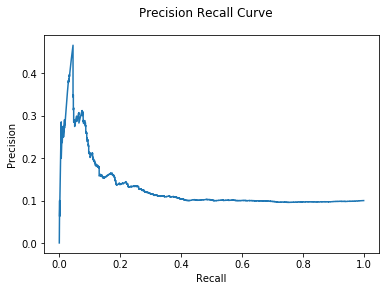

Wall time: 1min 19s


In [19]:
%%time
M = OddBall(G)
pred_probs = M.predict_proba(y=test_y['txId'])
auc, ax = evaluate(test_y["class"], pred_probs)
print("OddBall AUC: {:.2e}".format(auc))
plt.show()

Unfortunately, our model is not good at predicting illicit behavior in this dataset. However, as we already saw, identifying illegal behavior has more nuance than just identifying outliers. Let's focus on use cases where OddBall thrives:

### Use Cases of OddBall

The paper which describes the OddBall algorithm used a few different graphs to highlight its strenghts:

- The [Enron](http://www.cs.cmu.edu/~enron/) graph to identify noteworthy senders and recipients of emails. OddBall can use the power law theorem of nodes vs. 
- Data from the [Federal Election Commission](https://www.fec.gov/data/browse-data/?tab=bulk-data) to identify large donors and recipients of super PAC money.

### OddBall on Enron

In [20]:
enron = nx.read_edgelist(os.path.join(data_root, 'Enron', 'Enron.txt'), create_using=nx.DiGraph)
enron.size(), enron.order()

(367662, 36692)

In [21]:
x = []
y = []
nodes = []
for ego in enron.nodes():
    S = egonet(enron, ego)
    e = len(enron.edges(nbunch=S))
    if len(S) > 0 and e > 0:
        x.append(len(S))
        y.append(e)
        nodes.append(ego)

1.1898532131269226 45.424433441186316


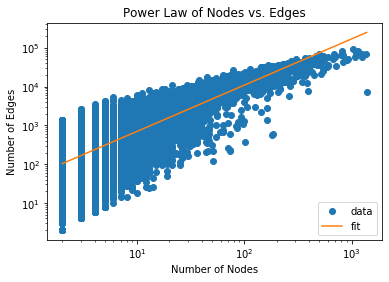

In [22]:
x_log = np.log(x)
y_log = np.log(y)
m, b = np.polyfit(x_log, y_log, 1)
C = np.exp(b)
theta = m
x_fit = np.unique(x)
y_fit = C * (x_fit ** theta)
plt.title('Power Law of Nodes vs. Edges')
plt.plot(x, y, 'o', label="data")
plt.plot(x_fit, y_fit, label="fit")
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Edges')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
print(theta, C)
plt.show()

In [23]:
scores = []
for v, X, gt in zip(nodes, x, y):
    inference = C * (X ** theta)
    scores.append( (max(gt, inference) / min(gt, inference)) * np.log(np.abs(gt - inference) + 1) )

In [24]:
np.array(nodes)[np.argsort(scores)[-10:]]

array(['36163', '36150', '8344', '36135', '9137', '20764', '33806',
       '5069', '5022', '5038'], dtype='<U5')

These are the 10 most out-of-place nodes, according to OddBall focusing on the power law of nodes vs. edges. i.e., these are nodes who's neighborhood has a widely outlying number of edges given its size (it is eigther a near star, or a near clique, both of which are unlikely in large real-world graphs) OddBall can quickly identify these nodes as particularly outstanding nodes. Pairing up the node ids with users shows that the highest outlier pertain to the at the time CEO Kenneth Lay.

### OddBall on Political Candidate Donation Data

Here we make use of the power law theorem concerning edge weight to identify large donors or large committees receiving donations.

In [25]:
donations = nx.read_edgelist(os.path.join(data_root, "donations", "donations.csv"), delimiter=",", data=[("amount", float)], create_using=nx.DiGraph)
donations.size(), donations.order()

(2129346, 1385646)

In [26]:
x = []
y = []
nodes = []
for ego in donations.nodes():
    S = egonet(donations, ego)
    weights = [d['amount'] for _, _, d in donations.edges(nbunch=S, data=True)]
    totalweight = sum(weights)
    if len(weights) > 0 and totalweight > 0:
        nodes.append(ego)
        x.append(len(weights))
        y.append(totalweight)

0.8318466425038167 1102.3570364147965


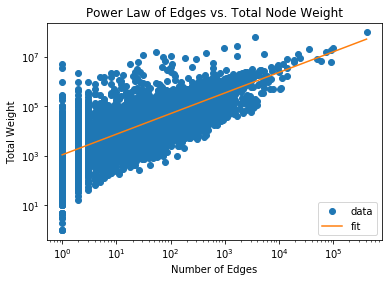

In [27]:
x_log = np.log(x)
y_log = np.log(y)
m, b = np.polyfit(x_log, y_log, 1)
C = np.exp(b)
theta = m
x_fit = np.unique(x)
y_fit = C * (x_fit ** theta)
plt.title('Power Law of Edges vs. Total Node Weight')
plt.plot(x, y, 'o', label="data")
plt.plot(x_fit, y_fit, label="fit")
plt.xlabel('Number of Edges')
plt.ylabel('Total Weight')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
print(theta, C)
plt.show()

In [28]:
scores = []
for v, X, gt in zip(nodes, x, y):
    inference = C * (X ** theta)
    scores.append( (max(gt, inference) / min(gt, inference)) * np.log(np.abs(gt - inference) + 1) )

In [29]:
np.array(nodes)[np.argsort(scores)[-10:]]

array(['C00553164', 'C00544007', 'C00637785', 'C00697227', 'C00571703',
       'C00701656', 'C00490847', 'C00657866', 'C00489815', 'C00693382'],
      dtype='<U9')

These are the committees that have significantly high contributions from a fewer number of powerful contributors. These committees are in order of highest to lowest outlier scores:

1. C00693382: DEMOCRACY PAC
1. C00489815: NEA ADVOCACY FUND
1. C00657866: PROTECT FREEDOM POLITICAL ACTION COMMITTEE
1. C00490847: WORKING FOR WORKING AMERICANS FEDERAL
1. C00701656: ENGAGE TEXAS
1. C00571703: SENATE LEADERSHIP FUND
1. C00697227: ELECT HENRY HEWES 2020
1. C00637785: D.D. ADAMS FOR CONGRESS
1. C00544007: FRIENDS OF ROY CHO INC.
1. C00553164: DAVID M ALAMEEL FOR UNITED STATES SENATE

## Conclusion

Depending on what you want to identify, outlier detection can be a challenging task with a bunch of different angles one can take to solve the problem. Each algorithm mentioned here has its merits and drawbacks, and each could in the right context do well to identify certain outliers given the right input data and search parameters.